In [ ]:
pip install smogn

In [ ]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import smogn
import random
import warnings

from sklearn.model_selection import train_test_split
from sklearn.metrics import r2_score, mean_squared_error
from sklearn.impute import SimpleImputer
from sklearn.compose import ColumnTransformer
from sklearn.preprocessing import StandardScaler, OneHotEncoder
from sklearn.pipeline import Pipeline
from sklearn.decomposition import PCA
from sklearn.linear_model import LassoCV
from sklearn.feature_selection import SelectFromModel
from xgboost import XGBRegressor
from pandas.errors import PerformanceWarning

warnings.simplefilter(action="ignore", category=PerformanceWarning)


In [ ]:

df = pd.read_excel('/content/deduplicated_by_mode.xlsx')

columns_to_drop = [
    "Continent", "NCC-16-cases", "NCC-18-cases", "Low CIN-16-cases", "Low CIN-18-cases",
    "High CIN-16-cases", "High CIN-18-cases", "ICC - 16 - any - cases", "ICC - 16 - SCC - cases",
    "ICC - 16 - ADC - cases", "ICC - 18 - any - cases", "ICC - 18 - SCC - cases",
    "ICC - 18 - ADC - cases", 'Sample size studied', 'ICC prevalence',
    'High CIN prevalence', 'Low CIN prevalence'
]
df.drop(columns=columns_to_drop, errors='ignore', inplace=True)


In [ ]:
df["TB_Incidence_Percent"] = (df["Incidence of TB"] / df["Population estimate"]) * 100
disease_cols = ["TB_Incidence_Percent", "Hypertension", "Diabetes Prevalence"]
df_norm = df[disease_cols].apply(lambda x: (x - x.min()) / (x.max() - x.min()))
df["Disease_Incidence_Score"] = df_norm.mean(axis=1)
df.drop(columns=disease_cols, inplace=True)


In [ ]:

def convert_screening_year(value):
    if pd.isnull(value): return np.nan
    if isinstance(value, str) and value.strip().lower() in ["not started", "unknown"]:
        return 0
    try: return int(value)
    except: return np.nan

df["Screening_Start_Year"] = df["Start of Screening coverage (year)"].apply(convert_screening_year)

circumcision_col = "Male circumcision (WHO 2007)"
if circumcision_col in df.columns:
    df["Male circumcision category"] = df[circumcision_col].map({"<20": "Low", "20-80": "Medium", ">80": "High"})
    df.drop(columns=[circumcision_col], inplace=True)

sti_cols = [
    'STI_SyphilisRate_rateper100k_2021',
    'STI_ChlamydialInfectionRate_rateper100k_2021',
    'STDRates_GonococcalInfectionRate_rateper100k_2021'
]
df_sti_norm = df[sti_cols].apply(lambda x: (x - x.min()) / (x.max() - x.min()))
df['STI_Score'] = df_sti_norm.mean(axis=1)
df.drop(columns=sti_cols, inplace=True)


In [ ]:

df['High_CIN_combined'] = df[['High CIN-16-prevalence', 'High CIN-18-prevalence']].mean(axis=1, skipna=True)

df.drop(columns=[
    "NCC-16-prevalence", "NCC-18-prevalence", "Low CIN-16-prevalence", "Low CIN-18-prevalence",
    "High CIN-16-prevalence", "High CIN-18-prevalence", "ICC - 16 - any - prevalence",
    "ICC - 16 - SCC - prevalence", "ICC - 16 - ADC - prevalence", "ICC - 18 - any - prevalence",
    "ICC - 18 - SCC - prevalence", "ICC - 18 - ADC - prevalence","Start of Screening coverage (year)"
], inplace=True)

df = df.dropna(subset=["High_CIN_combined"])


In [ ]:
X_all = df.drop(columns=["High_CIN_combined"])
y_all = df["High_CIN_combined"]

X_all = X_all.drop(columns=['Country', 'economy'], errors='ignore')  # Avoid high-cardinality dummy vars
X_encoded = pd.get_dummies(X_all, drop_first=True)

imputer = SimpleImputer(strategy='median')
X_encoded_imputed = imputer.fit_transform(X_encoded)

lasso = LassoCV(cv=5, random_state=42).fit(X_encoded_imputed, y_all)
selector = SelectFromModel(lasso, threshold=-np.inf, prefit=True)
selected_features = X_encoded.columns[selector.get_support()]
X_selected_df = pd.DataFrame(X_encoded_imputed[:, selector.get_support()], columns=selected_features)

df_stable = pd.concat([X_selected_df, y_all.reset_index(drop=True)], axis=1)


In [ ]:
np.random.seed(42)
random.seed(42)

df_smogn = smogn.smoter(
    data=df_stable,
    y="High_CIN_combined",
    k=5,
    samp_method='extreme',
    rel_thres=0.7
).copy()


r_index: 100%|##########| 2/2 [00:00<00:00, 104.34it/s]


In [ ]:
X = df_smogn.drop(columns=["High_CIN_combined"])
y = df_smogn["High_CIN_combined"]

numeric_cols = X.select_dtypes(include=['int64', 'float64']).columns.tolist()
categorical_cols = X.select_dtypes(include=['object', 'category', 'bool']).columns.tolist()
X[categorical_cols] = X[categorical_cols].astype(str)

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)


In [ ]:
numeric_transformer = Pipeline([
    ('imputer', SimpleImputer(strategy='median')),
    ('scaler', StandardScaler())
])

categorical_transformer = Pipeline([
    ('imputer', SimpleImputer(strategy='most_frequent')),
    ('encoder', OneHotEncoder(handle_unknown='ignore', sparse_output=False))
])

preprocessor = ColumnTransformer([
    ('num', numeric_transformer, numeric_cols),
    ('cat', categorical_transformer, categorical_cols)
])


In [ ]:
best_params = {
    'n_estimators': 200,
    'max_depth': 4,
    'learning_rate': 0.010432920541221915,
    'subsample': 0.858663879924028,
    'colsample_bytree': 0.7469584920796172,
    'gamma': 2.85974989985308,
    'reg_alpha': 2.4259824683569735,
    'reg_lambda': 4.906137291714221
}

final_model = Pipeline([
    ('preprocessor', preprocessor),
    ('pca', PCA(n_components=0.95, svd_solver='full')),
    ('xgb', XGBRegressor(objective='reg:squarederror', random_state=42, **best_params))
])

final_model.fit(X_train, y_train)
y_train_pred = final_model.predict(X_train)
y_test_pred = final_model.predict(X_test)


In [ ]:
def relative_rmse(y_true, y_pred):
    rmse = np.sqrt(mean_squared_error(y_true, y_pred))
    return rmse / np.mean(y_true)

print("🔧 Used Hyperparameters:", best_params)
print(f"Train R²: {r2_score(y_train, y_train_pred):.4f}")
print(f"Test R²:  {r2_score(y_test, y_test_pred):.4f}")
print(f"Train MSE: {mean_squared_error(y_train, y_train_pred):.4f}")
print(f"Test MSE:  {mean_squared_error(y_test, y_test_pred):.4f}")
print(f"Train Relative RMSE: {relative_rmse(y_train, y_train_pred):.4f}")
print(f"Test Relative RMSE:  {relative_rmse(y_test, y_test_pred):.4f}")


🔧 Used Hyperparameters: {'n_estimators': 200, 'max_depth': 4, 'learning_rate': 0.010432920541221915, 'subsample': 0.858663879924028, 'colsample_bytree': 0.7469584920796172, 'gamma': 2.85974989985308, 'reg_alpha': 2.4259824683569735, 'reg_lambda': 4.906137291714221}
Train R²: 0.9054
Test R²:  0.8018
Train MSE: 20.1099
Test MSE:  47.9016
Train Relative RMSE: 0.1143
Test Relative RMSE:  0.1802


In [ ]:
y_train_pred = final_model.predict(X_train)


In [ ]:
# -----------------------------
# TEACHER KNOWLEDGE (GLOBAL PRIOR)
# -----------------------------
teacher_mean = np.mean(y_train_pred)
teacher_std  = np.std(y_train_pred)

print("Teacher HPV mean:", teacher_mean)
print("Teacher HPV std :", teacher_std)


Teacher HPV mean: 39.795834
Teacher HPV std : 10.829081


In [ ]:
# Take a single row (reshape for transformer)
sample = X_train.iloc[[0]]

# Transform using the fitted preprocessor (works always!)
sample_transformed = final_model.named_steps['preprocessor'].transform(sample)


In [ ]:
original_feature_names = numeric_cols
print(original_feature_names)


['Anemia prevalence among women of reproductive age (% of women ages 15-49)', 'Anemia prevalence among non-pregnant women (% of women ages 15-49)', 'Physicians per 1,000 people', 'Anemia prevalence among pregnant women (%)', 'Mean targeted age', 'Population estimate', 'Smoking Prevalence (Current smoking prevalence females, 2016)', 'Total Fertility rate (2017)', 'Contraception use (updated 2019)', 'HIV Prevalence (in adults)', 'Sexual Initiation age', 'Mean marital age', 'Multiple pregnancies (%age)', 'Condom Use', 'HPV vaccination introduction', 'Age adjusted incidence (standardized rates)', 'Number of deaths (all ages, 2021)', 'Mortality rates (age standardized)', 'Human Development Index (HDI)', 'Life expectancy at birth', 'Expected years of schooling', 'Mean years of schooling', 'Gross national income (GNI) per capita', 'Incidence of TB', 'HPV Vaccine', 'Coverage ever screened of women 30 - 49 years (%)', 'Coverage in last 5 years of women 30 - 49 years (%) ', 'Coverage in last 3 y

In [ ]:
print("Categorical columns:", categorical_cols)
print("Number of categorical columns:", len(categorical_cols))


Categorical columns: []
Number of categorical columns: 0


In [ ]:
import shap

# Transform training data
X_train_transformed = final_model.named_steps['preprocessor'].transform(X_train)
X_train_pca = final_model.named_steps['pca'].transform(X_train_transformed)

# Correct estimator step name
estimator = final_model.named_steps['xgb']

# SHAP explainer
explainer = shap.Explainer(estimator, X_train_pca)

# Compute SHAP values
shap_values = explainer(X_train_pca).values


In [ ]:
# ---------------------------------------------------------
# 1. Identify Top PCA Components from SHAP
# ---------------------------------------------------------

import numpy as np

# SHAP mean absolute importance for each PCA component
pca_importance = np.mean(np.abs(shap_values), axis=0)

# Sort components by importance
top_pca_indices = np.argsort(pca_importance)[::-1]

print("\nTop PCA Components by SHAP importance:")
for i in range(10):
    comp_idx = top_pca_indices[i]
    print(f"{i+1}. PCA_Component_{comp_idx+1} (importance = {pca_importance[comp_idx]:.4f})")


# ---------------------------------------------------------
# 2. For each important PCA component, extract top features
# ---------------------------------------------------------

# PCA component loadings matrix: shape (n_components, n_original_features)
pca_loadings = final_model.named_steps['pca'].components_

num_top_features = 10  # number of original features to list

all_feature_contributions = []  # collect for later global ranking

for comp_idx in top_pca_indices[:10]:   # top 10 PCA components
    print(f"\nTop {num_top_features} original features for PCA_Component_{comp_idx+1}:")

    component_loadings = pca_loadings[comp_idx]

    # absolute value for importance ranking
    abs_loadings = np.abs(component_loadings)


    top_feature_idx = np.argsort(abs_loadings)[::-1][:num_top_features]

    for i in top_feature_idx:
        weight = component_loadings[i]
        print(f"{original_feature_names[i]}   (loading = {weight:.4f})")


        all_feature_contributions.append((original_feature_names[i], abs(weight)))


feature_importance = {}

for feat, weight in all_feature_contributions:
    feature_importance[feat] = feature_importance.get(feat, 0) + weight

ranked_features = sorted(feature_importance.items(), key=lambda x: x[1], reverse=True)

print("\n\n==============================")
print("FINAL RANKED REAL FEATURES")
print("==============================")
for feat, score in ranked_features[:20]:
    print(f"{feat}: {score:.4f}")



Top PCA Components by SHAP importance:
1. PCA_Component_13 (importance = 4.2253)
2. PCA_Component_2 (importance = 4.1267)
3. PCA_Component_9 (importance = 1.6218)
4. PCA_Component_1 (importance = 0.8486)
5. PCA_Component_10 (importance = 0.5916)
6. PCA_Component_11 (importance = 0.3027)
7. PCA_Component_6 (importance = 0.2829)
8. PCA_Component_8 (importance = 0.2333)
9. PCA_Component_14 (importance = 0.1948)
10. PCA_Component_15 (importance = 0.1741)

Top 10 original features for PCA_Component_13:
HPV vaccination introduction   (loading = 0.5245)
Condom Use   (loading = 0.4717)
HPV Vaccine   (loading = 0.3910)
Screening_Start_Year   (loading = 0.3579)
Contraception use (updated 2019)   (loading = 0.1886)
Disease_Incidence_Score   (loading = -0.1595)
Expected years of schooling   (loading = -0.1447)
Incidence of TB   (loading = -0.1364)
Male circumcision category_Medium   (loading = 0.1359)
Mean marital age   (loading = 0.1107)

Top 10 original features for PCA_Component_2:
Male circum

In [ ]:

student_df = pd.read_excel('Indian_states_cleaned_data.xlsx')

states = student_df['State']
X_student = student_df.drop(columns=['State'], errors='ignore')


In [ ]:
from sklearn.pipeline import Pipeline
from sklearn.impute import SimpleImputer
from sklearn.preprocessing import StandardScaler
from sklearn.linear_model import Ridge

student_pipeline = Pipeline([
    ('imputer', SimpleImputer(strategy='median')),
    ('scaler', StandardScaler()),
    ('model', Ridge(alpha=1.0))
])


In [ ]:
y_student_soft = np.random.normal(
    loc=teacher_mean,
    scale=teacher_std,
    size=len(X_student)
)


In [ ]:
student_pipeline.fit(X_student, y_student_soft)


Pipeline(steps=[('imputer', SimpleImputer(strategy='median')),
                ('scaler', StandardScaler()), ('model', Ridge())])

In [ ]:
student_predictions = student_pipeline.predict(X_student)

student_results = pd.DataFrame({
    'State': states,
    'Predicted_HPV_Prevalence': student_predictions
})

print(student_results.head())


                       State  Predicted_HPV_Prevalence
0  Andaman & Nicobar Islands                 31.833844
1             Andhra Pradesh                 40.677947
2          Arunachal Pradesh                 47.957312
3                      Assam                 26.179420
4                      Bihar                 55.191098


In [ ]:
student_results.to_excel(
    'Indian_Statewise_HPV_Predictions_hign_cin_combined.xlsx',
    index=False
)


In [ ]:


y_teacher_global = final_model.predict(X_train)

teacher_mean = np.mean(y_teacher_global)
teacher_std  = np.std(y_teacher_global)

print("Teacher mean:", teacher_mean)
print("Teacher std :", teacher_std)


Teacher mean: 39.795834
Teacher std : 10.829081


In [ ]:


np.random.seed(42)

y_teacher_soft = np.random.normal(
    loc=teacher_mean,
    scale=teacher_std,
    size=len(X_student)
)


In [ ]:
from sklearn.linear_model import Ridge

student_model = Ridge(alpha=1.0)

student_pipeline.fit(X_student, y_teacher_soft)

y_student_pred = student_pipeline.predict(X_student)



In [ ]:
from sklearn.metrics import mean_squared_error, r2_score
from scipy.stats import spearmanr

distill_rmse = np.sqrt(mean_squared_error(y_teacher_soft, y_student_pred))
distill_r2 = r2_score(y_teacher_soft, y_student_pred)

spearman_corr, _ = spearmanr(y_teacher_soft, y_student_pred)

print("\n==============================")
print("STUDENT MODEL EVALUATION High CIN")
print("==============================")
print(f"Distillation RMSE : {distill_rmse:.4f}")
print(f"Distillation R²   : {distill_r2:.4f}")
print(f"Spearman Corr     : {spearman_corr:.4f}")



STUDENT MODEL EVALUATION High CIN
Distillation RMSE : 7.3780
Distillation R²   : 0.4810
Spearman Corr     : 0.6973


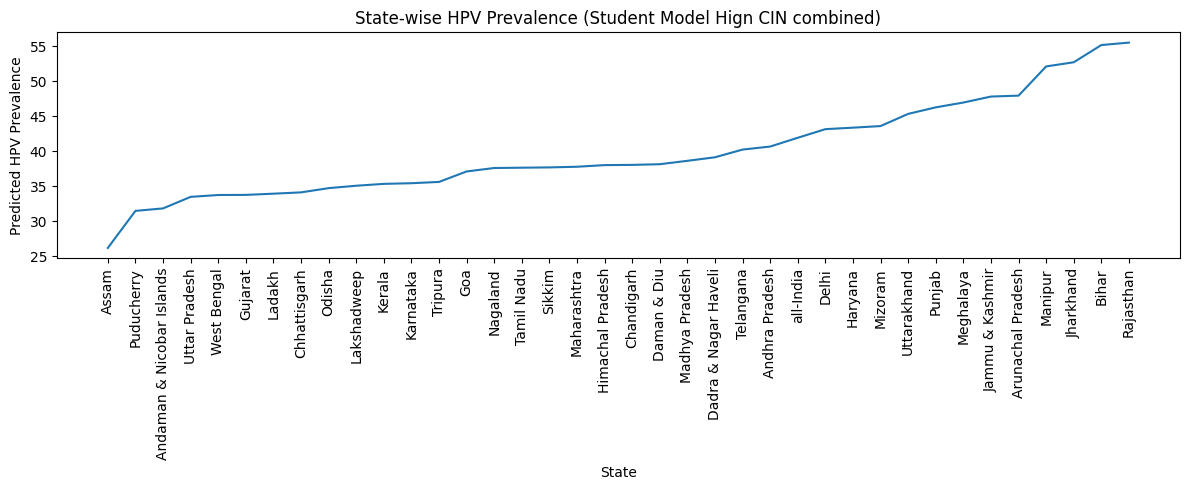

In [ ]:
import matplotlib.pyplot as plt
import pandas as pd


student_results = pd.DataFrame({
    "State": states,
    "Predicted_HPV_Prevalence": student_predictions
}).sort_values("Predicted_HPV_Prevalence")


plt.figure(figsize=(12, 5))
plt.plot(
    student_results["State"],
    student_results["Predicted_HPV_Prevalence"]
)

plt.xticks(rotation=90)
plt.ylabel("Predicted HPV Prevalence")
plt.xlabel("State")
plt.title("State-wise HPV Prevalence (Student Model Hign CIN combined)")
plt.tight_layout()
plt.show()
